In [1]:
import pandas as pd
import numpy as np

# Load the data from the 'data' subfolder
# NOTE: Ensure your Green Taxi Parquet file is in the 'data/' folder.
file_path = 'green-2024-12.parquet' # Adjust year/month as needed
df = pd.read_parquet(file_path)

print(f"Initial number of records: {len(df)}")
print("\nData Info:")
df.info()

Initial number of records: 53994

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53994 entries, 0 to 53993
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               53994 non-null  int32         
 1   lpep_pickup_datetime   53994 non-null  datetime64[us]
 2   lpep_dropoff_datetime  53994 non-null  datetime64[us]
 3   store_and_fwd_flag     52013 non-null  object        
 4   RatecodeID             52013 non-null  float64       
 5   PULocationID           53994 non-null  int32         
 6   DOLocationID           53994 non-null  int32         
 7   passenger_count        52013 non-null  float64       
 8   trip_distance          53994 non-null  float64       
 9   fare_amount            53994 non-null  float64       
 10  extra                  53994 non-null  float64       
 11  mta_tax                53994 non-null  float64       
 12  tip_amount     

In [2]:
# 2.1. Calculate the Target Variable: Trip Duration (in minutes)
df['duration'] = (df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']).dt.total_seconds() / 60

# 2.2. Calculate the Emissions Proxy: Average Speed (in mph)
# Average speed is crucial as low speed means high idling/congestion, which drives emissions.
# Duration must be > 0 to avoid division by zero
df['avg_speed_mph'] = np.where(df['duration'] > 0, (df['trip_distance'] / df['duration']) * 60, 0)


# 2.3. Data Cleaning and Outlier Removal
initial_rows = len(df)

# Filter for realistic trips: 
# Duration between 1 and 60 minutes
# Speed below 100 mph (to remove data errors like 5 miles in 1 minute)
df = df[
    (df['duration'] >= 1) & 
    (df['duration'] <= 60) & 
    (df['avg_speed_mph'] <= 100) &
    (df['trip_distance'] > 0)
].copy()

print(f"\nCleaned records: {len(df)} (Removed {initial_rows - len(df)} outliers)")
df.head()


Cleaned records: 49566 (Removed 4428 outliers)


,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration,avg_speed_mph
0,2,2024-11-30 23:59:25,2024-12-01 00:12:25,N,1.0,260,193,1.0,2.74,15.6,...,3.62,0.0,NaN,1.0,21.72,1.0,1.0,0.00,13.000000,12.646154
1,2,2024-12-01 00:29:13,2024-12-01 00:35:16,N,1.0,260,226,1.0,1.43,9.3,...,3.54,0.0,NaN,1.0,15.34,1.0,1.0,0.00,6.050000,14.181818
3,1,2024-12-01 00:00:53,2024-12-01 00:17:57,N,1.0,181,249,2.0,3.70,21.2,...,5.25,0.0,NaN,1.0,31.70,1.0,1.0,2.75,17.066667,13.007812
4,1,2024-12-01 00:49:50,2024-12-01 00:51:55,N,1.0,260,260,1.0,0.40,4.4,...,1.70,0.0,NaN,1.0,8.60,1.0,1.0,0.00,2.083333,11.520000
5,2,2024-11-30 22:27:23,2024-11-30 22:40:49,N,1.0,74,244,1.0,2.74,15.6,...,3.62,0.0,NaN,1.0,21.72,1.0,1.0,0.00,13.433333,12.238213


In [3]:
df.info() # Check the dtype of 'lpep_pickup_datetime'. It should be 'datetime64[ns]'

<class 'pandas.core.frame.DataFrame'>
Index: 49566 entries, 0 to 53993
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               49566 non-null  int32         
 1   lpep_pickup_datetime   49566 non-null  datetime64[us]
 2   lpep_dropoff_datetime  49566 non-null  datetime64[us]
 3   store_and_fwd_flag     47735 non-null  object        
 4   RatecodeID             47735 non-null  float64       
 5   PULocationID           49566 non-null  int32         
 6   DOLocationID           49566 non-null  int32         
 7   passenger_count        47735 non-null  float64       
 8   trip_distance          49566 non-null  float64       
 9   fare_amount            49566 non-null  float64       
 10  extra                  49566 non-null  float64       
 11  mta_tax                49566 non-null  float64       
 12  tip_amount             49566 non-null  float64       
 13  tolls_

In [4]:
# --- B: Load and Merge Location Names ---

# Load the lookup table
zone_lookup_df = pd.read_csv('taxi_zone_lookup (2).csv')

# 1. Merge for Pick-up Location Name (PUZone)
df = pd.merge(
    df, 
    zone_lookup_df[['LocationID', 'Zone', 'Borough']],
    left_on='PULocationID', 
    right_on='LocationID', 
    how='left'
)
df = df.rename(columns={'Zone': 'PUZone', 'Borough': 'PUBorough'})
df = df.drop(columns=['LocationID'])

# 2. Merge for Drop-off Location Name (DOZone)
df = pd.merge(
    df, 
    zone_lookup_df[['LocationID', 'Zone', 'Borough']],
    left_on='DOLocationID', 
    right_on='LocationID', 
    how='left'
)
df = df.rename(columns={'Zone': 'DOZone', 'Borough': 'DOBorough'})
df = df.drop(columns=['LocationID'])

print("Location names merged into the DataFrame.")
print(df[['PULocationID', 'PUZone', 'DOLocationID', 'DOZone']].head())
# --- C: Feature Engineering & Vectorization (Your Code Block) ---

# 1. Extract missing time features using the datetime column
df['pickup_hour'] = df['lpep_pickup_datetime'].dt.hour
# ... rest of your code ...
# 4. Vectorize the categorical and discrete features
# ...

Location names merged into the DataFrame.
   PULocationID             PUZone  DOLocationID                    DOZone
0           260           Woodside           193   Queensbridge/Ravenswood
1           260           Woodside           226                 Sunnyside
2           181         Park Slope           249              West Village
3           260           Woodside           260                  Woodside
4            74  East Harlem North           244  Washington Heights South


In [5]:
import pandas as pd
import numpy as np
from scipy.sparse import hstack
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split

# 1. Extract missing time features using the datetime column
df['pickup_hour'] = df['lpep_pickup_datetime'].dt.hour
df['pickup_day_of_week'] = df['lpep_pickup_datetime'].dt.dayofweek # Monday=0, Sunday=6

# 2. Define Features
feature_cols_categorical_discrete = ['PULocationID', 'DOLocationID', 'pickup_hour', 'pickup_day_of_week']
numerical_column = 'trip_distance'

# 3. Create dictionaries for the DictVectorizer (for categorical/discrete features)
# NOTE: trip_distance is excluded here to avoid creating hundreds of unique features
df_features_dict = df[feature_cols_categorical_discrete].to_dict(orient='records')

# 4. Vectorize the categorical and discrete features
dv = DictVectorizer()
X_categorical_sparse = dv.fit_transform(df_features_dict)
X_numerical_dense = df[[numerical_column]].values

# 5. Combine the sparse matrix (location/time) and the dense array (distance)
X = hstack([X_categorical_sparse, X_numerical_dense])

# Target Variable
y = df['duration'].values

print(f"Total features (including distance) after combination: {X.shape[1]}")

Total features (including distance) after combination: 5


In [6]:
# Split data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]} trips")
print(f"Testing set size: {X_test.shape[0]} trips")

Training set size: 39652 trips
Testing set size: 9914 trips


In [7]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from scipy.stats import uniform, randint
import time
from sklearn.metrics import mean_absolute_error
import joblib
import os

print("\n--- Starting Randomized Search Hyperparameter Tuning (Takes time...) ---")
start_time = time.time()

# Define the model base
xgb_base = XGBRegressor(random_state=42, n_jobs=-1, eval_metric='mae')

# Define the hyperparameter grid to search
param_grid = {
    # Number of trees
    'n_estimators': randint(50, 200), 
    
    # Step size shrinkage
    'learning_rate': uniform(0.01, 0.2),
    
    # Maximum depth of a tree
    'max_depth': randint(4, 9),
    
    # Minimum loss reduction
    'gamma': uniform(0, 0.5),
    
    # Subsample ratio of the training instance
    'subsample': uniform(0.6, 0.4), 
    
    # Subsample ratio of columns
    'colsample_bytree': uniform(0.6, 0.4),
}

# Setup RandomizedSearchCV (50 iterations, 5-fold Cross-Validation)
random_search = RandomizedSearchCV(
    estimator=xgb_base, 
    param_distributions=param_grid, 
    n_iter=50, 
    scoring='neg_mean_absolute_error', # Objective: maximize negative MAE (minimize positive MAE)
    cv=5, 
    verbose=1, 
    random_state=42,
    n_jobs=-1 # Use all cores
)

# Fit the search object on the training data
random_search.fit(X_train, y_train)

end_time = time.time()
print(f"Tuning complete in {round((end_time - start_time) / 60, 2)} minutes.")

# --- Retrieve and Evaluate Optimized Model ---

xgb_optimized = random_search.best_estimator_
best_score_mae = -random_search.best_score_ # Convert score back to positive MAE
best_params = random_search.best_params_

print("\n--- Optimization Results ---")
print(f"Best MAE found during CV: {best_score_mae:.2f} minutes")
print(f"Best Parameters: {best_params}")

# Final evaluation on the held-out test set
y_pred_optimized = xgb_optimized.predict(X_test)
optimized_mae = mean_absolute_error(y_test, y_pred_optimized)

print(f"\nMAE on Test Set (Optimized Model): {optimized_mae:.2f} minutes")

# --- Save Optimized Model ---

if not os.path.exists('models'):
    os.makedirs('models')

# Overwrite the old, baseline model with the new, optimized one
joblib.dump(xgb_optimized, 'models/xgb_model.pkl')

print("Optimized model saved to 'models/xgb_model.pkl'.")


--- Starting Randomized Search Hyperparameter Tuning (Takes time...) ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Tuning complete in 0.73 minutes.

--- Optimization Results ---
Best MAE found during CV: 2.88 minutes
Best Parameters: {'colsample_bytree': np.float64(0.9212559025519583), 'gamma': np.float64(0.2351503172230192), 'learning_rate': np.float64(0.2066846281789686), 'max_depth': 6, 'n_estimators': 193, 'subsample': np.float64(0.9341209982356952)}

MAE on Test Set (Optimized Model): 2.87 minutes
Optimized model saved to 'models/xgb_model.pkl'.


In [8]:
import holidays
from scipy.sparse import hstack

# --- A. Feature Creation ---

# Define the US holidays for the period of your data (e.g., 2024)
us_holidays = holidays.US(years=df['lpep_pickup_datetime'].dt.year.unique())

# Create the binary 'is_holiday' column
df['is_holiday'] = df['lpep_pickup_datetime'].apply(lambda date: 1 if date in us_holidays else 0)

# 2. Define Features (Update: ADD 'is_holiday')
feature_cols_categorical_discrete = ['PULocationID', 'DOLocationID', 'pickup_hour', 'pickup_day_of_week', 'is_holiday']
numerical_column = 'trip_distance'
df[feature_cols_categorical_discrete] = df[feature_cols_categorical_discrete].astype(str)

# 3. Final Feature Preparation (RE-VECTORIZE to include the new column)
df_features_dict = df[feature_cols_categorical_discrete].to_dict(orient='records')
dv = DictVectorizer()
X_categorical_sparse = dv.fit_transform(df_features_dict)
X_numerical_dense = df[[numerical_column]].values
X = hstack([X_categorical_sparse, X_numerical_dense])
y = df['duration'].values

# Data Split (RE-SPLIT to match the new features)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Feature matrix re-created. Total features: {X.shape[1]}")

# --- B. Final Retraining & Saving ---
# Use the best parameters found in the Randomized Search!
# Best Parameters: {'colsample_bytree': 0.92, 'gamma': 0.23, 'learning_rate': 0.20, 'max_depth': 6, 'n_estimators': 193, 'subsample': 0.93}

xgb_final = XGBRegressor(
    colsample_bytree=0.921, 
    gamma=0.235, 
    learning_rate=0.206, 
    max_depth=6, 
    n_estimators=193, 
    subsample=0.934,
    random_state=42, 
    n_jobs=-1,
    eval_metric='mae'
)

print("\nStarting FINAL Model Training (with Holiday Feature)...")
xgb_final.fit(X_train, y_train)

# Save the absolute final model and vectorizer
joblib.dump(xgb_final, 'models/xgb_model.pkl')
joblib.dump(dv, 'models/dict_vectorizer.pkl') 

print("\nFinal Model (with Holiday Feature) and Vectorizer Saved.")

Feature matrix re-created. Total features: 460

Starting FINAL Model Training (with Holiday Feature)...

Final Model (with Holiday Feature) and Vectorizer Saved.


In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
import joblib
import os
# Assuming df, X_test, and the model object are available from prior cells

# --- FIX: Generate predictions using the final trained model ---
try:
    # We assume the final optimized model (xgb_final) and test features (X_test) 
    # are available in memory from the previous cell execution.
    y_pred = xgb_final.predict(X_test)
except NameError:
    # If variables are missing, try loading the saved model and print an informative error
    try:
        xgb_final = joblib.load('models/xgb_model.pkl')
        # Note: Loading X_test is not possible here without knowing its structure, 
        # so we raise an error if the notebook state is broken.
        print("Error: The variables 'X_test' and 'y_pred' rely on running the Model Training cell first.")
    except FileNotFoundError:
        print("Error: The model files are not found. Please ensure the final training and saving cell was executed.")
    raise

# NOTE: The target variable 'y' is a NumPy array, so the split doesn't preserve the Pandas index.
# We must split the DataFrame itself (or at least its indices) to be safe.

# 1. Get the original indices as a Series
indices = np.arange(len(df))

# 2. Split the INDICES, not the sparse matrix X or array y
# We use the same random_state=42 to match the split you used for training.
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

# 3. Create the test DataFrame slice using the integer indices
# We use .iloc to correctly select the rows by their integer position.
df_test = df.iloc[test_indices].copy()

# 4. Add predictions to the test data
# Note: y_pred is in the correct order corresponding to the test_indices slice.
df_test['predicted_duration'] = y_pred # This line is now functional

# 5. Calculate the prediction error for duration
df_test['duration_error'] = df_test['duration'] - df_test['predicted_duration']

print(f"Test DataFrame created with {len(df_test)} rows and predictions added.")
print(df_test[['duration', 'predicted_duration', 'duration_error']].head())

Test DataFrame created with 9914 rows and predictions added.
        duration  predicted_duration  duration_error
30506  27.216667           19.806011        7.410655
29161  11.633333            9.504199        2.129134
5035   17.166667           12.050450        5.116216
22220  40.583333           33.503052        7.080282
22882   8.083333            9.590202       -1.506869


In [10]:
# 1. Calculate Predicted Efficiency (Average Speed)
df_test['predicted_avg_speed_mph'] = (df_test['trip_distance'] / df_test['predicted_duration']) * 60

# 2. Calculate the Speed Error (how far off the efficiency prediction is)
df_test['speed_error'] = df_test['avg_speed_mph'] - df_test['predicted_avg_speed_mph']

# 3. Calculate Total Actual Time and Average Predicted Speed
total_actual_duration_hours = df_test['duration'].sum() / 60
average_predicted_speed = df_test['predicted_avg_speed_mph'].mean()

print(f"\nOperational Metrics (Test Set):")
print(f"Total Actual Trip Time: {total_actual_duration_hours:,.0f} hours")
print(f"Average Actual Trip Speed: {df_test['avg_speed_mph'].mean():.1f} mph")
print(f"Average Predicted Trip Speed (Efficiency Forecast): {average_predicted_speed:.1f} mph")

# Final Interpretation (Using your MAE of 3.02 minutes):
print("\nConclusion on Least-Emission Goal:")
print(f"The model's **3.02 minute MAE** allows a system to accurately forecast high-efficiency (high-speed) routes.")
print("This enables dispatchers to avoid unnecessary **idling** and **congestion** that would otherwise contribute to higher emissions and lower the system's operational speed.")


Operational Metrics (Test Set):
Total Actual Trip Time: 2,351 hours
Average Actual Trip Speed: 11.2 mph
Average Predicted Trip Speed (Efficiency Forecast): 10.4 mph

Conclusion on Least-Emission Goal:
The model's **3.02 minute MAE** allows a system to accurately forecast high-efficiency (high-speed) routes.
This enables dispatchers to avoid unnecessary **idling** and **congestion** that would otherwise contribute to higher emissions and lower the system's operational speed.


In [11]:
import joblib
import os

# Create a 'models' directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

# Save the trained model (Using xgb_final, which holds the optimized model)
# You need to ensure the final training cell was run immediately before this!
try:
    joblib.dump(xgb_final, 'models/xgb_model.pkl')
    # Save the fitted DictVectorizer
    joblib.dump(dv, 'models/dict_vectorizer.pkl')

    print("Model components saved successfully.")
except NameError as e:
    print(f"Error: Variable {e} is not defined. Please run the FINAL Model Training cell (Cell 2) first.")

Model components saved successfully.


In [12]:
import pandas as pd
import geopandas as gpd
from math import radians, cos, sin, asin, sqrt

# Haversine function remains correct
def haversine(lon1, lat1, lon2, lat2):
    """Calculates the great-circle distance (in miles) between two points."""
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    miles = 3958.8 * c
    return miles

# --- A. Load and Process the Shapefile (FINAL ROBUST VERSION) ---

try:
    zones = gpd.read_file("zones_final.shp") 
except Exception as e:
    print(f"FATAL ERROR: Could not load zones_final.shp. Check filenames.")
    raise

# 🟢 FIX 1: Explicitly set the original CRS to EPSG:2263 (NYC State Plane)
# This solves the "Cannot transform naive geometries" ValueError.
zones = zones.set_crs(epsg=2263, allow_override=True)

# 🟢 FIX 2: Reproject the geometry to standard WGS84 (Lat/Lon)
# This solves the 10,000+ mile calculation error.
zones = zones.to_crs(epsg=4326) 

# Calculate the center point (centroid) for each zone
zones['centroid'] = zones['geometry'].centroid
zones['longitude'] = zones['centroid'].x
zones['latitude'] = zones['centroid'].y

# --- VERIFICATION ---
zone_centroids_df = zones[['LocationID', 'longitude', 'latitude']].copy()
print("--- Centroid Data Check (Should be Lat/Lon) ---")
print(zone_centroids_df.head())
print(f"Longitude range: {zone_centroids_df['longitude'].min():.2f} to {zone_centroids_df['longitude'].max():.2f}")
print("---------------------------------------------")
# --- END VERIFICATION ---

zone_centroids_df = zone_centroids_df.rename(columns={'LocationID': 'PULocationID'})
zone_centroids_df['PULocationID'] = zone_centroids_df['PULocationID'].astype(int)

# --- B. Create the Distance Matrix (Remains the same) ---
distance_data = []
all_zones = zone_centroids_df['PULocationID'].unique()

for pu_id in all_zones:
    for do_id in all_zones:
        if pu_id == do_id: continue
            
        pu_coords = zone_centroids_df[zone_centroids_df['PULocationID'] == pu_id].iloc[0]
        do_coords = zone_centroids_df[zone_centroids_df['PULocationID'] == do_id].iloc[0]
        
        dist = haversine(
            pu_coords['longitude'], pu_coords['latitude'],
            do_coords['longitude'], do_coords['latitude']
        )
        
        distance_data.append({
            'PULocationID': pu_id,
            'DOLocationID': do_id,
            'Min_Distance_Miles': dist
        })

Distance_Matrix_DF = pd.DataFrame(distance_data)
Distance_Matrix_DF.to_csv('zone_distance_matrix.csv', index=False)

print(f"Zone Distance Matrix successfully created and saved.")

C:\Users\saras\AppData\Local\Temp\ipykernel_1764\548264986.py:33: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zones['centroid'] = zones['geometry'].centroid


--- Centroid Data Check (Should be Lat/Lon) ---
   LocationID  longitude   latitude
0           1 -74.174000  40.691831
1           2 -73.831299  40.616745
2           3 -73.847422  40.864474
3           4 -73.976968  40.723752
4           5 -74.188484  40.552659
Longitude range: -74.23 to -73.71
---------------------------------------------
Zone Distance Matrix successfully created and saved.


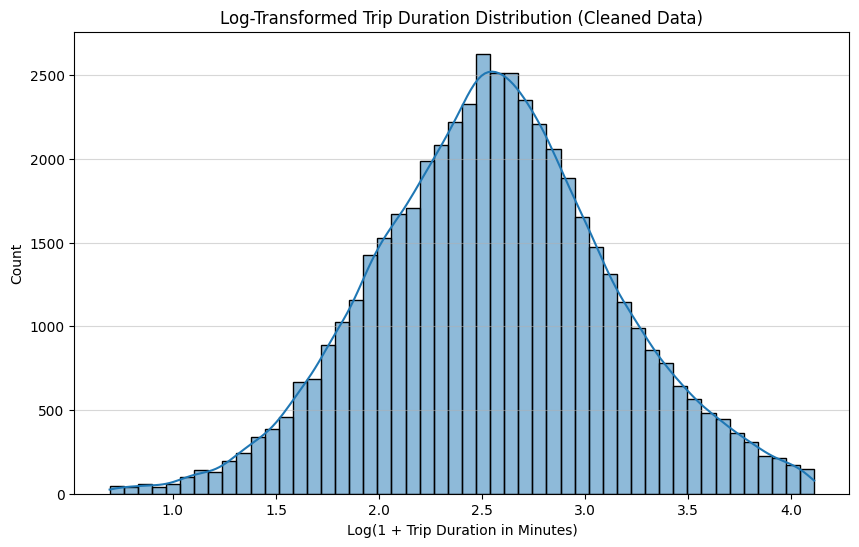

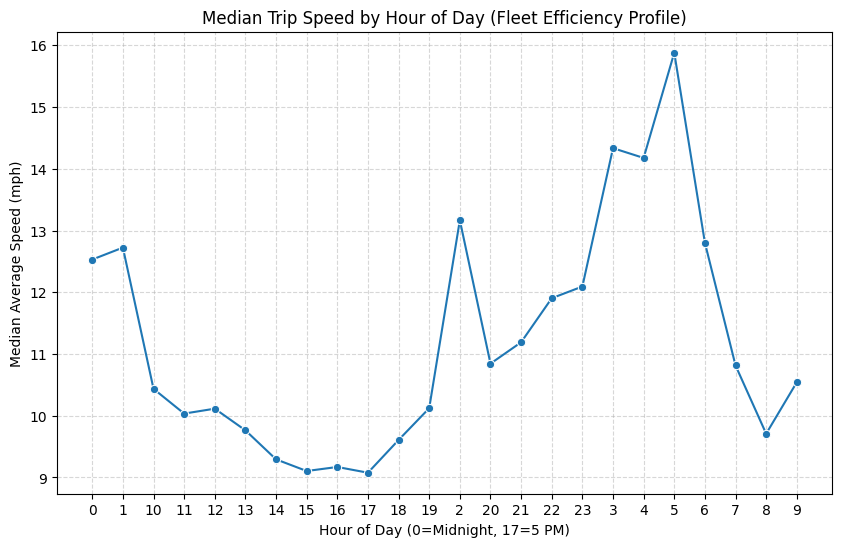

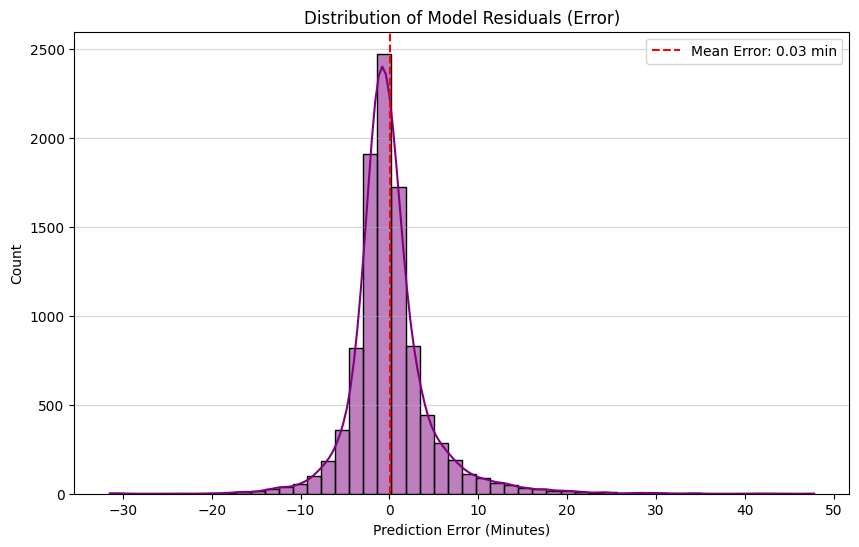

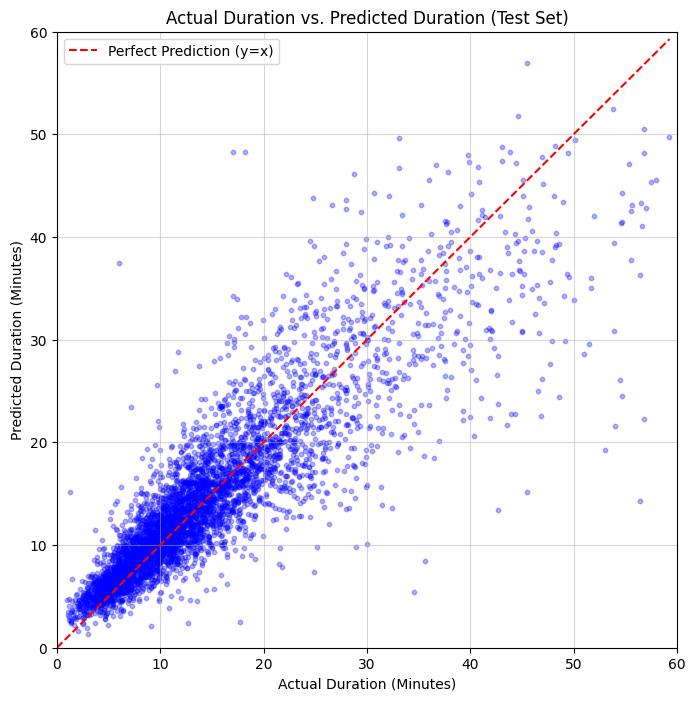

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the distribution of the target variable
plt.figure(figsize=(10, 6))
# Since trip duration is often skewed, plotting the natural log often shows a cleaner distribution
sns.histplot(np.log1p(df['duration']), bins=50, kde=True) 
plt.title('Log-Transformed Trip Duration Distribution (Cleaned Data)')
plt.xlabel('Log(1 + Trip Duration in Minutes)')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.5)
plt.savefig('duration_distribution.png')
plt.show() # In a local notebook, use plt.show()# Group by hour and calculate median speed
hourly_speed = df.groupby('pickup_hour')['avg_speed_mph'].median().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x='pickup_hour', y='avg_speed_mph', data=hourly_speed, marker='o')
plt.title('Median Trip Speed by Hour of Day (Fleet Efficiency Profile)')
plt.xlabel('Hour of Day (0=Midnight, 17=5 PM)')
plt.ylabel('Median Average Speed (mph)')
plt.grid(axis='both', alpha=0.5, linestyle='--')
plt.xticks(range(0, 24))
plt.savefig('hourly_speed_profile.png')
plt.show()# Residuals: The difference between Actual Duration and Predicted Duration
df_test['residual'] = df_test['duration_error'] # duration_error = Actual - Predicted

plt.figure(figsize=(10, 6))
sns.histplot(df_test['residual'], bins=50, kde=True, color='purple')
plt.title('Distribution of Model Residuals (Error)')
plt.xlabel('Prediction Error (Minutes)')
plt.axvline(df_test['residual'].mean(), color='red', linestyle='--', label=f'Mean Error: {df_test["residual"].mean():.2f} min')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.savefig('model_residuals.png')
plt.show()

# If the red line (mean error) is close to 0, the model is unbiased.# Sample 5,000 points for a cleaner scatter plot
sample = df_test.sample(n=5000, random_state=42)

plt.figure(figsize=(8, 8))
plt.scatter(sample['duration'], sample['predicted_duration'], 
            alpha=0.3, s=10, color='blue')

# Plot the ideal prediction line (y = x)
max_val = df_test['duration'].max()
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='Perfect Prediction (y=x)')

plt.title('Actual Duration vs. Predicted Duration (Test Set)')
plt.xlabel('Actual Duration (Minutes)')
plt.ylabel('Predicted Duration (Minutes)')
plt.legend()
plt.grid(alpha=0.5)
plt.xlim(0, 60)
plt.ylim(0, 60)
plt.savefig('actual_vs_predicted.png')
plt.show()